In [48]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np # to use numpy arrays instead of lists
import pandas as pd # DataFrame (table)
import matplotlib.pyplot as plt
import math

In [49]:
from sklearn.model_selection import train_test_split
import sklearn.decomposition as sk # to compute PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [50]:
def leeDatos():

    dataSet = pd.read_csv("PASAJEROS.csv", header=0, index_col=0)
    dataSet.index = pd.to_datetime(dataSet.index,format='%y,%m',errors='ignore')
    print(dataSet.head())
    print(dataSet.columns)

    return dataSet

def graficaDatos(dataSet=0):

    plt.figure()
    for i in range(len(dataSet.columns)):
        plt.plot(dataSet.iloc[:,i],label=dataSet.columns[i],marker=i+2,markevery=150)
    plt.grid(color='b',linestyle='dashed')
    plt.gcf().autofmt_xdate()
    plt.title('VENTAS', fontweight='bold')
    plt.xlabel('FECHA')
    plt.ylabel('VENTAS')
    plt.legend(loc='upper left')
    plt.show()

def linealizar(dataSet=0):
    """
    Normalize and smooth data
    """
    dataSet = dataSet.fillna(method='ffill')
    #dataSet = dataSet.dropna()

    # computing range of data for the regressions
    size = len(dataSet)
    x = range(size)
    numFeatures = len(dataSet.columns)

    for i in range(numFeatures):
        dataSet.iloc[:,i] = dataSet.iloc[:,i]  / dataSet.iloc[:,i].abs().max()
        polyCoef = np.polyfit(x, dataSet.iloc[:,i], 3)   # coefficients 10
        regModel = np.poly1d(polyCoef)              # equation
        regSpace = np.linspace(1, size, size)          # generate n numbers between a range
        dataSet.iloc[:,i] = regModel(regSpace)

    return dataSet


# --------------------
# split data
def splitDataSet(dataSet=0, test_size=.2, randSplit=False):
    """
    Split data in train and test sets
    """

    train, test = train_test_split(dataSet, test_size=test_size, shuffle=randSplit)

    return [train, test]

In [51]:
leeDatos()

         #PASAJEROS  VENTAS
FECHA                      
1949-01         112   33600
1949-02         118   35400
1949-03         132   39600
1949-04         129   38700
1949-05         121   36300
Index(['#PASAJEROS', 'VENTAS'], dtype='object')


,#PASAJEROS,VENTAS
FECHA,,
1949-01,112,33600
1949-02,118,35400
1949-03,132,39600
1949-04,129,38700
1949-05,121,36300
...,...,...
1960-08,606,181800
1960-09,508,152400
1960-10,461,138300


# ML methods

In [52]:
def metodosML(dataSet=0, dataSet2=0):
    # Definir encabezados para métricas
    methodsUsed = ['DT', 'RF']
    performanceHeaders = ['RSS', 'SSR', 'TSS', 'R-Square', 'Adj. R-Square']
    comperrHeaders = ['MSE', 'RMSE', 'MAPE']
    errorHeaders = ['Mean', 'Median', 'SD', '25%', '50%', '75%', 'Min', 'Max', 'Range']
    modPerformance = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance.index.name = "Model Performance"
    comperr = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr.index.name = "Error Metrics"
    regError = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError.index.name = "Relative Error"
    modPerformance3 = pd.DataFrame(index=methodsUsed, columns=performanceHeaders)
    modPerformance3.index.name = "Model Performance"
    comperr3 = pd.DataFrame(index=methodsUsed, columns=comperrHeaders)
    comperr3.index.name = "Error Metrics"
    regError3 = pd.DataFrame(index=methodsUsed, columns=errorHeaders)
    regError3.index.name = "Relative Error"

    # Preparar DataFrames para almacenar resultados
    trainModel = pd.DataFrame()
    testModel = pd.DataFrame()
    yModel = pd.DataFrame()
    yModel3 = pd.DataFrame()

    # Usar el índice como característica (convertir a numérico)
    dataSet = dataSet.reset_index()
    dataSet2 = dataSet2.reset_index()
    dataSet['FECHA'] = pd.to_datetime(dataSet['FECHA']).map(pd.Timestamp.toordinal)
    dataSet2['FECHA'] = pd.to_datetime(dataSet2['FECHA']).map(pd.Timestamp.toordinal)

    # Asignar la variable objetivo (VENTAS) a 'Raw Data'
    trainModel['Raw Data'] = dataSet['VENTAS']
    testModel['Raw Data'] = dataSet2['VENTAS']

    # Árbol de Decisión
    regr = DecisionTreeRegressor(max_depth=4)
    regr.fit(dataSet[['FECHA']].to_numpy(), dataSet['VENTAS'].to_numpy())
    
    # Datos de entrenamiento
    trainModel['Fitted DT'] = regr.predict(dataSet[['FECHA']].to_numpy())
    yModel['Fitted DT'] = trainModel['Fitted DT']
    yModel, regError, comperr, modPerformance = compareMethod(
        yModel, 'DT', dataSet, 'VENTAS', regError, comperr, modPerformance, 0
    )
    
    # Datos de prueba
    testModel['Fitted DT'] = regr.predict(dataSet2[['FECHA']].to_numpy())
    yModel3['Fitted DT'] = testModel['Fitted DT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(
        yModel3, 'DT', dataSet2, 'VENTAS', regError3, comperr3, modPerformance3, 0
    )

    # Bosques Aleatorios
    regr = RandomForestRegressor(n_estimators=4)
    regr.fit(dataSet[['FECHA']].to_numpy(), dataSet['VENTAS'].to_numpy())
    
    # Datos de entrenamiento
    trainModel['Fitted RT'] = regr.predict(dataSet[['FECHA']].to_numpy())
    yModel['Fitted RT'] = trainModel['Fitted RT']
    yModel, regError, comperr, modPerformance = compareMethod(
        yModel, 'RT', dataSet, 'VENTAS', regError, comperr, modPerformance, 1
    )
    
    # Datos de prueba
    testModel['Fitted RT'] = regr.predict(dataSet2[['FECHA']].to_numpy())
    yModel3['Fitted RT'] = testModel['Fitted RT']
    yModel3, regError3, comperr3, modPerformance3 = compareMethod(
        yModel3, 'RT', dataSet2, 'VENTAS', regError3, comperr3, modPerformance3, 1
    )

    # Restaurar FECHA como índice y formatearlo como YYYY-MM
    trainModel['FECHA'] = dataSet['FECHA'].apply(pd.Timestamp.fromordinal)
    trainModel['FECHA'] = trainModel['FECHA'].dt.strftime('%Y-%m')
    trainModel.set_index('FECHA', inplace=True)

    testModel['FECHA'] = dataSet2['FECHA'].apply(pd.Timestamp.fromordinal)
    testModel['FECHA'] = testModel['FECHA'].dt.strftime('%Y-%m')
    testModel.set_index('FECHA', inplace=True)

    # Imprimir resultados
    print("=======================================================================")
    print("                      MODEL PERFORMANCE COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(modPerformance.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print("-----------------------------------------------------------------------")
    print(modPerformance3.T)
    print("=======================================================================")
    print("                      ERROR METRICS")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(comperr.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(comperr3.T)
    print("=======================================================================")
    print("                      MAPE (RELATIVE ERROR) COMPARISON")
    print("-----------------------------------------------------------------------")
    print("                      Training")
    print("-----------------------------------------------------------------------")
    print(regError.T)
    print("-----------------------------------------------------------------------")
    print("                      Testing")
    print(regError3.T)
    print("\n")

    return [trainModel, testModel]

In [53]:
def compareMethod(yModel, method, dataSet, y, regError, comperr, modPerformance, i):
    name_fit = 'Fitted ' + method
    name_res = 'Residuals ' + method
    name_err = 'Rel Error_' + method

    size = len(yModel)

    # compute residuals and relative error
    yModel[name_res] = dataSet[y] - yModel[name_fit]  # Cambiado de iloc[:, y] a dataSet[y]
    yModel[name_err] = (1 - (yModel[name_fit] / dataSet[y])).abs()  # Cambiado de iloc[:, y] a dataSet[y]
    regError.iloc[i, 0] = yModel[name_err].mean(axis=0)
    regError.iloc[i, 1] = yModel[name_err].median(axis=0)
    regError.iloc[i, 2] = yModel[name_err].std(axis=0)
    regError.iloc[i, 3] = yModel[name_err].quantile(q=.25)
    regError.iloc[i, 4] = yModel[name_err].quantile(q=.5)
    regError.iloc[i, 5] = yModel[name_err].quantile(q=.75)
    regError.iloc[i, 6] = yModel[name_err].min()
    regError.iloc[i, 7] = yModel[name_err].max()
    regError.iloc[i, 8] = regError.iloc[i, 7] - regError.iloc[i, 6]

    # Models Performance
    modPerformance.iloc[i, 0] = (yModel[name_res] ** 2).sum()
    modPerformance.iloc[i, 1] = ((yModel[name_fit] - dataSet[y].mean(axis=0)) ** 2).sum()  # Cambiado de iloc[:, y] a dataSet[y]
    modPerformance.iloc[i, 2] = modPerformance.iloc[i, 0] + modPerformance.iloc[i, 1]
    modPerformance.iloc[i, 3] = 1 - modPerformance.iloc[i, 0] / modPerformance.iloc[i, 2]
    modPerformance.iloc[i, 4] = 1 - (1 - modPerformance.iloc[i, 3]) * ((size - 1) / (size - 4 - 1))

    # error metrics
    comperr.iloc[i, 0] = modPerformance.iloc[i, 0] / size
    comperr.iloc[i, 1] = comperr.iloc[i, 0] ** (1 / 2)
    comperr.iloc[i, 2] = regError.iloc[i, 0]

    return (yModel, regError, comperr, modPerformance)

         #PASAJEROS  VENTAS
FECHA                      
1949-01         112   33600
1949-02         118   35400
1949-03         132   39600
1949-04         129   38700
1949-05         121   36300
Index(['#PASAJEROS', 'VENTAS'], dtype='object')
         #PASAJEROS  VENTAS
FECHA                      
1949-01         112   33600
1949-02         118   35400
1949-03         132   39600
1949-04         129   38700
1949-05         121   36300
...             ...     ...
1960-08         606  181800
1960-09         508  152400
1960-10         461  138300
1960-11         390  117000
1960-12         432  129600

[144 rows x 2 columns]
         VENTAS
FECHA          
1949-01   33600
1949-02   35400
1949-03   39600
1949-04   38700
1949-05   36300
...         ...
1960-08  181800
1960-09  152400
1960-10  138300
1960-11  117000
1960-12  129600

[144 rows x 1 columns]


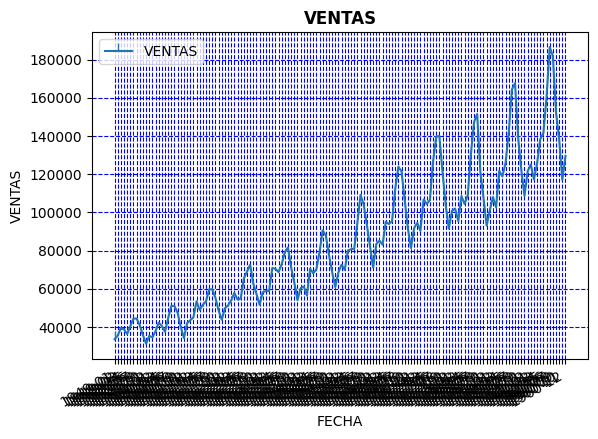

In [54]:
datos = leeDatos()
print(datos)

ventas = ['VENTAS']
misDatos = datos[ventas]
print(datos[ventas])

graficaDatos(misDatos.iloc[0:144,:])

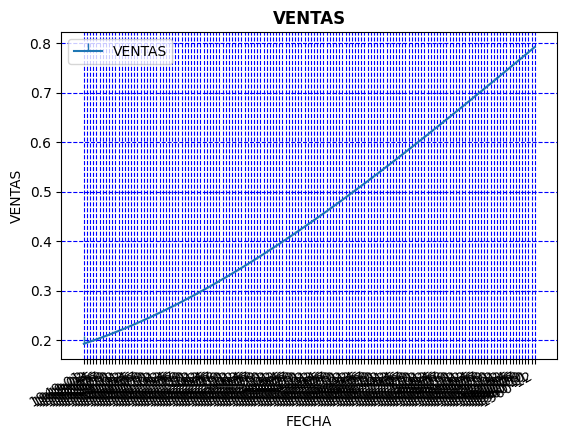

In [55]:
datosLin = linealizar(misDatos.iloc[0:290,:])

graficaDatos(datosLin)

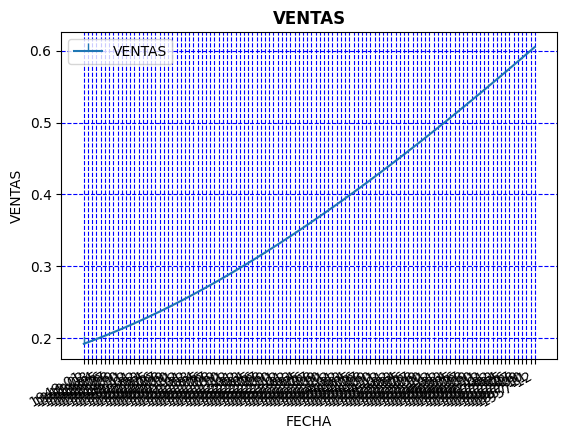

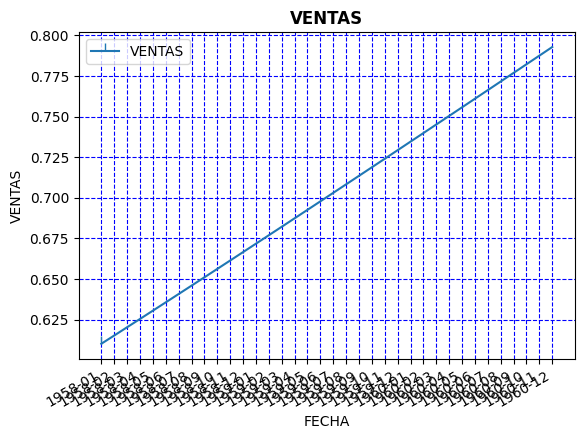

In [56]:
ts_size = .25
[trainSet, testSet] = splitDataSet(datosLin, test_size=ts_size, randSplit=False)

graficaDatos(trainSet)
graficaDatos(testSet)

                      MODEL PERFORMANCE COMPARISON
-----------------------------------------------------------------------
                      Training
-----------------------------------------------------------------------
Model Performance        DT        RF
RSS                 0.00591  0.000234
SSR                1.616172   1.62081
TSS                1.622081  1.621044
R-Square           0.996357  0.999856
Adj. R-Square      0.996215   0.99985
-----------------------------------------------------------------------
                      Testing
-----------------------------------------------------------------------
Model Performance        DT        RF
RSS                0.507955  0.443738
SSR                0.402119  0.337902
TSS                0.910075  0.781639
R-Square           0.441853  0.432299
Adj. R-Square      0.369834  0.359047
                      ERROR METRICS
-----------------------------------------------------------------------
                      Training
-----

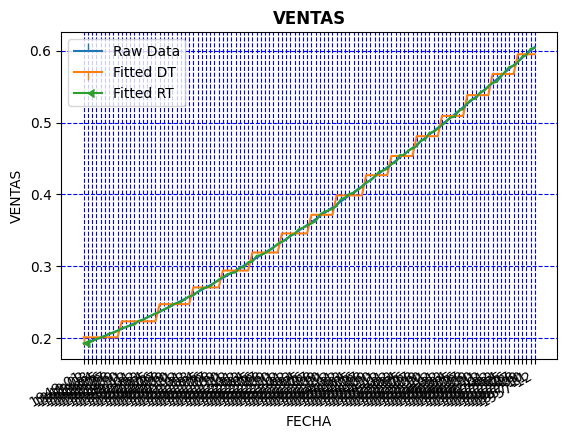

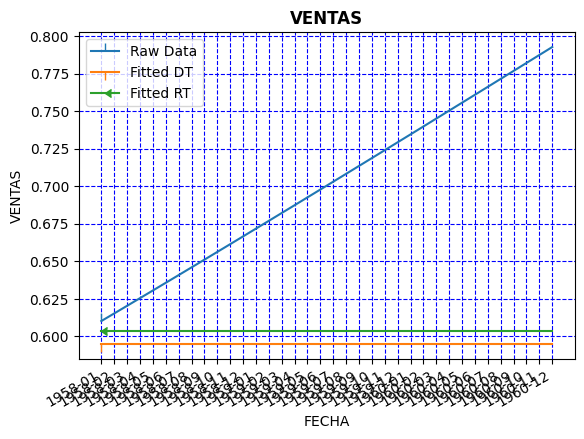

In [57]:
[trainModel, testModel] = metodosML(trainSet, testSet)

graficaDatos(trainModel)
graficaDatos(testModel)